In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gnnboundary import *

In [3]:
import torch
import numpy as np

# ENZYMES

In [4]:
dataset = ENZYMESDataset(seed=12345)

In [5]:
model = GCNClassifier(node_features=len(dataset.NODE_CLS),
                      num_classes=len(dataset.GRAPH_CLS),
                      hidden_channels=32,
                      num_layers=3)
model.load_state_dict(torch.load('ckpts/enzymes.pt'))

<All keys matched successfully>

In [6]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)
print(dataset_list_pred)

[ENZYMESDataset(90), ENZYMESDataset(91), ENZYMESDataset(106), ENZYMESDataset(91), ENZYMESDataset(106), ENZYMESDataset(116)]


In [7]:
evaluation = dataset.model_evaluate(model)
evaluation

{'acc': 0.7350000143051147,
 'cm': array([[65,  3,  5,  9,  7, 11],
        [ 5, 65,  8,  8,  7,  7],
        [ 4,  4, 83,  1,  1,  7],
        [ 9,  6,  1, 71,  5,  8],
        [ 3,  5,  6,  0, 80,  6],
        [ 4,  8,  3,  2,  6, 77]]),
 'f1': {'EC1': 0.6842105388641357,
  'EC2': 0.6806282997131348,
  'EC3': 0.8058252334594727,
  'EC4': 0.7434554696083069,
  'EC5': 0.7766990065574646,
  'EC6': 0.7129629850387573}}

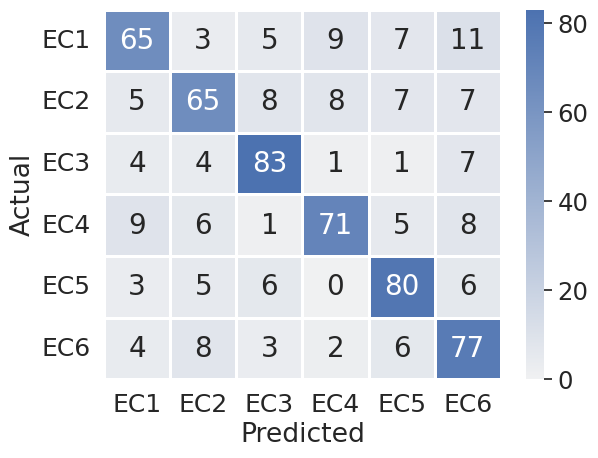

In [8]:
draw_matrix(evaluation['cm'], dataset.GRAPH_CLS.values(), fmt='d')

In [9]:
mean_embeds = [d.model_transform(model, key="embeds").mean(dim=0) for d in dataset_list_gt]

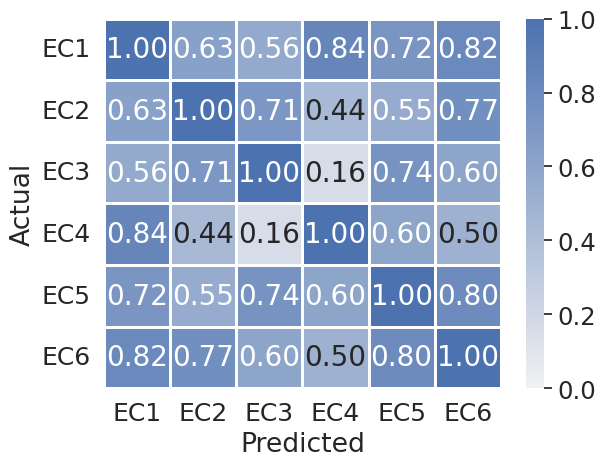

In [10]:
adj_ratio_mat, boundary_info = pairwise_boundary_analysis(model, dataset_list_pred)
draw_matrix(adj_ratio_mat, names=dataset.GRAPH_CLS.values(), fmt='.2f')


In [10]:
from lib.boundary.multi_boundary_analysis import triangular_boundary_analysis

result = triangular_boundary_analysis(model, dataset_list_pred, threshold=0.2)
print(result)

{(0, 1, 2): [0.67, 0.84, 0.56], (0, 1, 3): [0.65, 0.48, 0.72], (0, 1, 4): [0.68, 0.51, 0.72], (0, 1, 5): [0.65, 0.82, 0.79], (0, 2, 3): [0.59, 0.21, 0.8], (0, 2, 4): [0.52, 0.69, 0.81], (0, 2, 5): [0.59, 0.68, 0.82], (0, 3, 4): [0.8, 0.66, 0.71], (0, 3, 5): [0.77, 0.46, 0.74], (0, 4, 5): [0.77, 0.69, 0.73], (1, 2, 4): [0.85, 0.76, 0.51], (1, 2, 5): [0.88, 0.62, 0.82], (1, 3, 4): [0.42, 0.66, 0.5], (1, 3, 5): [0.5, 0.45, 0.79], (1, 4, 5): [0.54, 0.78, 0.75], (2, 4, 5): [0.76, 0.8, 0.69], (3, 4, 5): [0.72, 0.69, 0.43]}


In [ ]:
import numpy as np

print(adj_ratio_mat)
np.savetxt('adj_enzymes.txt', adj_ratio_mat, fmt='%f')

In [11]:
trainer = {}
sampler = {}
from lib.trainer import GPUTrainer
from lib.trainer import NewTrainer

# 0 & 1 & 5

In [70]:
cls_1, cls_2, cls_3 = 2, 4, 5
trainer[cls_1, cls_2, cls_3] = NewTrainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.15,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=1
        ), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_3]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=15, order=2, beta=1),
    min_iteration=500
)

In [71]:
cls_1, cls_2, cls_3 = 2, 4, 5
p_min = 0.266
p_max = 0.4
trainer[cls_1, cls_2, cls_3].train(
    iterations=2000,
    target_probs={cls_1: (p_min, p_max), cls_2: (p_min, p_max), cls_3: (p_min, p_max)},
    target_size=50,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=32
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

logits=[-28.714271545410156, -25.90483283996582, -24.484996795654297, -30.409669876098633, -25.416807174682617, -25.551115036010742]
probs=[0.007291784510016441, 0.1210479810833931, 0.5007079839706421, 0.0013382327742874622, 0.19719886779785156, 0.17241507768630981]
n=17 m=28


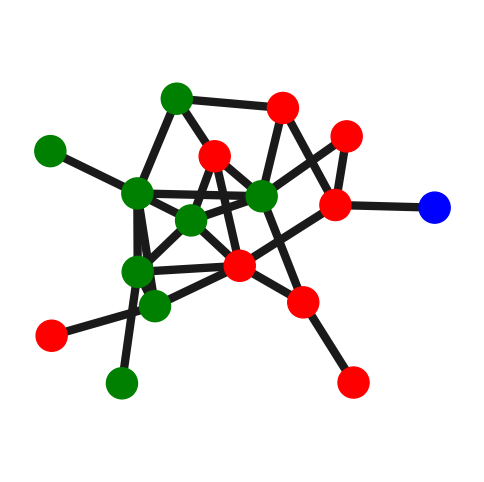

In [72]:
cls_1, cls_2, cls_3 = 2, 4, 5

trainer[cls_1, cls_2, cls_3].evaluate(threshold=0.5, show=True, bernoulli=True)

In [76]:
res = trainer[cls_1, cls_2, cls_3].quantitative(sample_size=500)
print(res["mean"])
print(res["std"])

[0.00532596 0.10563847 0.35421868 0.00161021 0.33351814 0.19968853]
[0.0023505  0.09275686 0.18901702 0.00487605 0.22640737 0.1167612 ]


# 0 & 4 & 5

In [184]:
cls_1, cls_2, cls_3 = 0, 4, 5
trainer[cls_1, cls_2, cls_3] = NewTrainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=1
        ), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_3]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=15, order=2, beta=1),
)

In [ ]:
cls_1, cls_2, cls_3 = 0, 4, 5
trainer[cls_1, cls_2, cls_3].train(
    iterations=2000,
    target_probs={cls_1: (0.25, 0.4), cls_2: (0.25, 0.4), cls_3: (0.25, 0.4)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

In [ ]:
trainer[cls_1, cls_2, cls_3].evaluate(threshold=0.5, show=True)

# 2 & 4 & 5

In [266]:
cls_1, cls_2, cls_3 = 2, 4, 5
trainer[cls_1, cls_2, cls_3] = NewTrainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=1
        ), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_3]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=15, order=2, beta=1),
)

In [ ]:
cls_1, cls_2, cls_3 = 2, 4, 5
trainer[cls_1, cls_2, cls_3].train(
    iterations=2000,
    target_probs={cls_1: (0.233, 0.4), cls_2: (0.233, 0.4), cls_3: (0.233, 0.4)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

In [ ]:
trainer[cls_1, cls_2, cls_3].evaluate(threshold=0.5, show=True, bernoulli=True)

# 0 & 3

In [26]:
cls_1, cls_2 = 0, 3
trainer[cls_1, cls_2] = NewTrainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=1
        ), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=15, order=2, beta=1),
)

In [ ]:
cls_1, cls_2 = 0, 3
trainer[cls_1, cls_2].train(
    iterations=2000,
    target_probs={cls_1: (0.40, 0.6), cls_2: (0.40, 0.6)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

In [ ]:
trainer[0, 3].evaluate(threshold=0.5, show=True)

In [ ]:
res = trainer[0, 3].quantitative(sample_size=500)

print(res)

# 0 & 4

In [111]:
cls_1, cls_2 = 0, 4
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=2, beta=1
        ), weight=15),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=1),
        dict(key="logits", criterion=MeanPenalty(), weight=5),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [ ]:
cls_1, cls_2 = 0, 4
trainer[cls_1, cls_2].train(
    iterations=2000,
    target_probs={cls_1: (0.4, 0.6), cls_2: (0.4, 0.6)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

In [ ]:
trainer[0, 4].evaluate(threshold=0.5, show=True)

In [ ]:
res = trainer[0, 4].quantitative(sample_size=1000)

print(res)

# 0 & 5

In [72]:
cls_1, cls_2 = 0, 5
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=2, beta=1
        ), weight=15),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=1),
        dict(key="logits", criterion=MeanPenalty(), weight=5),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [ ]:
cls_1, cls_2 = 0, 5
trainer[cls_1, cls_2].train(
    iterations=2000,
    target_probs={cls_1: (0.4, 0.6), cls_2: (0.4, 0.6)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

In [ ]:
trainer[0, 5].evaluate(threshold=0.5, show=True)

# 1 & 2

In [56]:
cls_1, cls_2 = 1, 2
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=1
        ), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [ ]:
cls_1, cls_2 = 1, 2
trainer[cls_1, cls_2].train(
    iterations=2000,
    target_probs={cls_1: (0.4, 0.6), cls_2: (0.4, 0.6)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

In [ ]:
trainer[1, 2].evaluate(threshold=0.5, show=True)

# 1 & 5

In [62]:
cls_1, cls_2 = 1, 5
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=2
        ), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=15, order=2, beta=1),
)

In [ ]:
cls_1, cls_2 = 1, 5
trainer[cls_1, cls_2].train(
    iterations=2000,
    target_probs={cls_1: (0.4, 0.6), cls_2: (0.4, 0.6)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

In [ ]:
trainer[1, 5].evaluate(threshold=0.5, show=True)

# 2 & 4

In [74]:
cls_1, cls_2 = 2, 4
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=1
        ), weight=10),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=1),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=15, order=2, beta=1),
)

In [ ]:
cls_1, cls_2 = 2, 4
trainer[cls_1, cls_2].train(
    iterations=2000,
    target_probs={cls_1: (0.4, 0.6), cls_2: (0.4, 0.6)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

In [ ]:
trainer[2, 4].evaluate(threshold=0.5, show=True)

# 3 & 4

In [16]:
cls_1, cls_2 = 3, 4
trainer[cls_1, cls_2] = NewTrainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=5, beta=1
        ), weight=20),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=1),
        dict(key="logits", criterion=MeanPenalty(), weight=5),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
    ]),
    optimizer=(o := torch.optim.Adam(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [ ]:
cls_1, cls_2 = 3, 4
trainer[cls_1, cls_2].train(
    iterations=2000,
    target_probs={cls_1: (0.4, 0.6), cls_2: (0.4, 0.6)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

n=20 m=33
logits=[-63.85671615600586, -75.9887924194336, -66.11829376220703, -45.27288818359375, -41.085792541503906, -51.79591369628906]
probs=[1.2710320296260846e-10, 6.843254884437153e-16, 1.3242373343713698e-11, 0.014962716028094292, 0.9850152730941772, 2.198348011006601e-05]


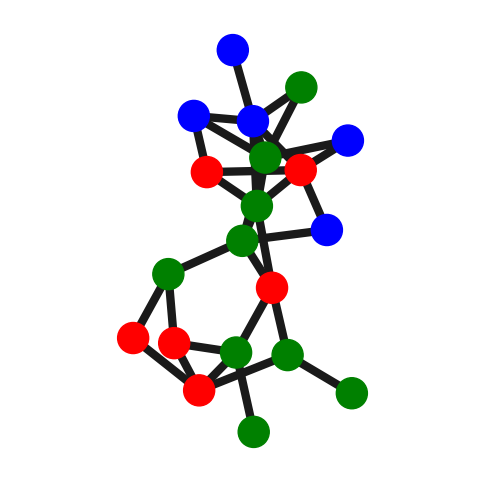

In [14]:
trainer[3, 4].evaluate(threshold=0.5, show=True)

In [15]:
res = trainer.quantitative(sample_size=500)

AttributeError: 'dict' object has no attribute 'quantitative'

# 4 & 5

In [ ]:
cls_1, cls_2 = 4, 5
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=1
        ), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=15, order=2, beta=1),
)

In [ ]:
cls_1, cls_2 = 4, 5
trainer[cls_1, cls_2].train(
    iterations=2000,
    target_probs={cls_1: (0.4, 0.6), cls_2: (0.4, 0.6)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

In [ ]:
trainer[4, 5].evaluate(threshold=0.5, show=True)